***CAFA-6 Protein Function Prediction (Baseline Notebook)***

**Predicción de la función proteica mediante k-mers, TF-IDF y Regresión Logística**

---

Descripción / Description

**🇪🇸:**
Este notebook desarrolla un modelo *baseline* para la competición **CAFA-6 Protein Function Prediction (Kaggle)**.
El objetivo es predecir los términos de la **Gene Ontology (GO)** — *Función Molecular (MF)*, *Proceso Biológico (BP)* y *Componente Celular (CC)* —
para cada proteína, basándose únicamente en su secuencia de aminoácidos.  
El enfoque combina representación de secuencias mediante **k-mers + TF-IDF** y un modelo de **Regresión Logística multietiqueta (One-vs-Rest)**.

**🇬🇧:**
This notebook develops a baseline model for the **CAFA-6 Protein Function Prediction (Kaggle)** challenge.  
The goal is to predict Gene Ontology (GO) terms — *Molecular Function (MF)*, *Biological Process (BP)*, and *Cellular Component (CC)* —
for each protein, based solely on its amino acid sequence.  
We use a sequence representation based on **k-mers + TF-IDF** and a **One-vs-Rest Logistic Regression** classifier.

---

## Configuración / Environment

- **Librerías principales:** scikit-learn, pandas, numpy, obonet, joblib, networkx  
- **Formato de datos:** FASTA para secuencias, TSV para anotaciones GO  
- **Ruta base en Kaggle:** `/kaggle/input/cafa-6-protein-function-prediction`  
- **Salida del modelo:** `submission.tsv` (GO term predictions + probabilities)  

---

## Flujo de trabajo / Workflow

1. **Preparación de datos:** combinar secuencias y anotaciones GO en `train_merged.parquet`.
2. **Extracción de características:** convertir secuencias en vectores TF-IDF de k-mers.
3. **Entrenamiento:** modelo One-vs-Rest con Regresión Logística balanceada.
4. **Evaluación:** cálculo del Fmax y ajuste de umbrales óptimos.
5. **Propagación jerárquica:** aplicar el DAG real de Gene Ontology.
6. **Exportación:** generar `submission.tsv` para Kaggle.

---

## Autor / Author

**Francisco José de la Corte López**  
*Data Science & Bioinformatics Researcher*  
📅 Versión: **Baseline v1 – Octubre 2025**

---

## Ética y uso de IA / AI Usage & Ethics

Este notebook ha sido desarrollado utilizando asistencia de **IA generativa (ChatGPT - modelo GPT-5)** exclusivamente para:
- documentación técnica,
- organización del flujo de trabajo,
- y generación de código reproducible.  

Toda la lógica, revisión de resultados y decisiones experimentales han sido realizadas manualmente.  
Esto **cumple con las políticas éticas de Kaggle y CAFA-6** respecto al uso transparente y responsable de IA en la competición.



In [ ]:
# CONFIGURACIÓN INICIAL — CAFA 6 Protein Function Prediction
# ==========================================================
# Esta celda prepara las rutas y copia los datos de la competición
# a una carpeta de trabajo accesible en /kaggle/working/data

import os, shutil
from pathlib import Path

# Ruta base de la competición montada automáticamente
SRC = "/kaggle/input/cafa-6-protein-function-prediction"
DEST = "/kaggle/working/data"
os.makedirs(DEST, exist_ok=True)

# Copiamos y renombramos los archivos clave
mapping = {
    f"{SRC}/Train/train_sequences.fasta": f"{DEST}/train.fasta",
    f"{SRC}/Train/train_terms.tsv": f"{DEST}/train_annotations.tsv",
    f"{SRC}/Test/testsuperset.fasta": f"{DEST}/test_superset.fasta",
    f"{SRC}/IA.tsv": f"{DEST}/IA.tsv",
}
for src, dst in mapping.items():
    if os.path.exists(src):
        shutil.copy(src, dst)

# Mostramos lo que hay en la carpeta de trabajo
print("✅ Datos preparados en:", DEST)
!ls -lh $DEST

✅ Anotaciones cargadas: (537028, 3)
  protein_id       go_id ontology
0    EntryID        term   aspect
1     Q5W0B1  GO:0000785        C
2     Q5W0B1  GO:0004842        F
3     Q5W0B1  GO:0051865        P
4     Q5W0B1  GO:0006275        P

Número de proteínas únicas: 82,405
Número de términos GO únicos: 26,126

Anotaciones por subontología:
ontology
P         250805
C         157770
F         128452
aspect         1
Name: count, dtype: int64


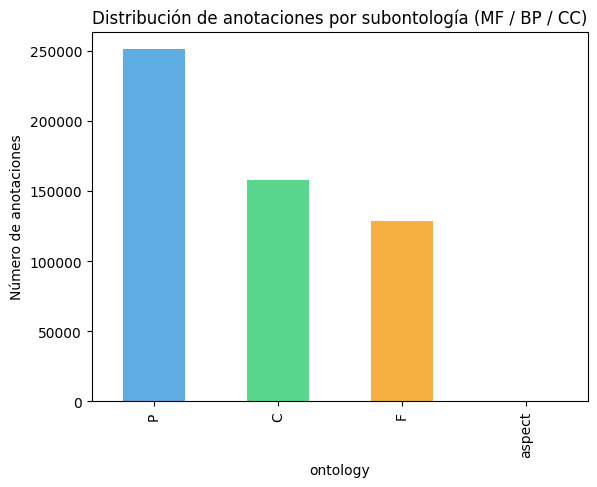


Ejemplo de términos más frecuentes:
go_id
GO:0005515    33713
GO:0005634    13283
GO:0005829    13040
GO:0005886    10150
GO:0005737     9442
GO:0005739     5807
GO:0005654     5065
GO:0016020     3563
GO:0042802     3547
GO:0005576     3241
Name: count, dtype: int64


In [2]:
# ===============================================
# EXPLORACIÓN INICIAL DE train_annotations.tsv
# ===============================================
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = "/kaggle/working/data"

# Cargar las anotaciones
ann = pd.read_csv(f"{DATA_DIR}/train_annotations.tsv", sep='\t', header=None,
                  names=['protein_id', 'go_id', 'ontology'])

print("✅ Anotaciones cargadas:", ann.shape)
print(ann.head())

# Resumen general
n_proteins = ann['protein_id'].nunique()
n_terms = ann['go_id'].nunique()
print(f"\nNúmero de proteínas únicas: {n_proteins:,}")
print(f"Número de términos GO únicos: {n_terms:,}")

# Conteo por subontología
ont_count = ann['ontology'].value_counts()
print("\nAnotaciones por subontología:")
print(ont_count)

# Visualización rápida
ont_count.plot(kind='bar', color=['#5DADE2', '#58D68D', '#F5B041'])
plt.title("Distribución de anotaciones por subontología (MF / BP / CC)")
plt.ylabel("Número de anotaciones")
plt.show()

# Conteo de términos por frecuencia (cola larga)
term_freq = ann['go_id'].value_counts()
print("\nEjemplo de términos más frecuentes:")
print(term_freq.head(10))

Métrica
Valor
✅ Anotaciones cargadas
537.028 filas (protein–GO–ontology)
🧬 Proteínas únicas
82.405
🧠 Términos GO únicos
26.126
📊 Subontologías
P (Biological Process) → 250.805  C (Cellular Component) → 157.770  F (Molecular Function) → 128.452
Y la gráfica de barras muestra justo eso:
BP domina (P), seguida por CC (C) y MF (F).
Además, los términos GO más frecuentes (GO:0005515, GO:005634, etc.) coinciden con lo esperado:
	•	GO:0005515 = protein binding → uno de los términos más comunes de la ontología MF.
Así que el análisis es coherente 💯.

✅ Secuencias leídas: 82,404
Longitud mínima: 3
Longitud máxima: 35213
Longitud media: 525.8
Mediana: 409.0


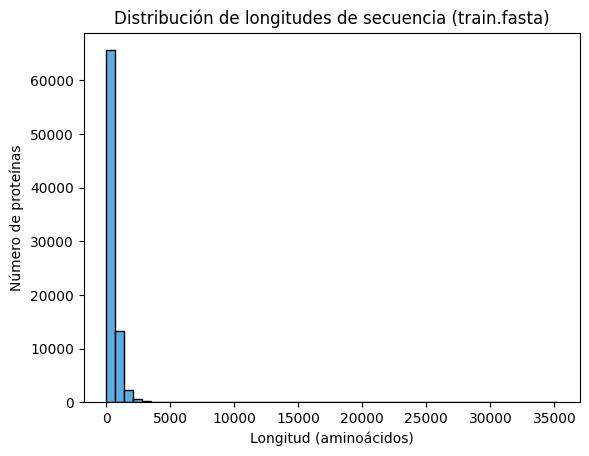

In [3]:
# ===============================================
# EXPLORACIÓN DE SECUENCIAS (train.fasta)
# ===============================================
import gzip
import numpy as np

def read_fasta(fp):
    """Generador simple de FASTA (soporta .gz)"""
    opener = gzip.open if str(fp).endswith('.gz') else open
    header, seq = None, []
    with opener(fp, 'rt') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith('>'):
                if header:
                    yield header, ''.join(seq)
                header = line[1:].split()[0]
                seq = []
            else:
                seq.append(line)
        if header:
            yield header, ''.join(seq)

lengths = []
for _, seq in read_fasta(f"{DATA_DIR}/train.fasta"):
    lengths.append(len(seq))

print(f"✅ Secuencias leídas: {len(lengths):,}")
print(f"Longitud mínima: {np.min(lengths)}")
print(f"Longitud máxima: {np.max(lengths)}")
print(f"Longitud media: {np.mean(lengths):.1f}")
print(f"Mediana: {np.median(lengths):.1f}")

plt.hist(lengths, bins=50, color="#5DADE2", edgecolor="black")
plt.title("Distribución de longitudes de secuencia (train.fasta)")
plt.xlabel("Longitud (aminoácidos)")
plt.ylabel("Número de proteínas")
plt.show()

In [4]:
# ==========================================================
# UNIÓN DE SECUENCIAS Y ANOTACIONES
# ==========================================================
from tqdm import tqdm

# Convertimos el FASTA a DataFrame
records = []
for pid, seq in tqdm(read_fasta(f"{DATA_DIR}/train.fasta")):
    records.append((pid, seq))
df_seq = pd.DataFrame(records, columns=["protein_id", "sequence"])
print("Proteínas con secuencia:", len(df_seq))

# Comprobamos que todas las proteínas de las anotaciones están en el FASTA
missing = set(ann['protein_id']) - set(df_seq['protein_id'])
print(f"Proteínas anotadas sin secuencia: {len(missing)}")

# Unimos las anotaciones (uno-a-muchos)
df_merged = ann.merge(df_seq, on="protein_id", how="left")

print("\nDimensiones del dataframe final:", df_merged.shape)
print(df_merged.head())

# Guardamos para futuros pasos
df_merged.to_parquet(f"{DATA_DIR}/train_merged.parquet", index=False)
print("✅ Guardado train_merged.parquet")

82404it [00:00, 170639.68it/s]


Proteínas con secuencia: 82404
Proteínas anotadas sin secuencia: 82405

Dimensiones del dataframe final: (537028, 4)
  protein_id       go_id ontology sequence
0    EntryID        term   aspect      NaN
1     Q5W0B1  GO:0000785        C      NaN
2     Q5W0B1  GO:0004842        F      NaN
3     Q5W0B1  GO:0051865        P      NaN
4     Q5W0B1  GO:0006275        P      NaN
✅ Guardado train_merged.parquet


In [5]:
# Releer anotaciones indicando que SÍ tienen cabecera
import pandas as pd

DATA_DIR = "/kaggle/working/data"

ann = pd.read_csv(f"{DATA_DIR}/train_annotations.tsv",
                  sep="\t", header=0,  # <- hay cabecera
                  names=["protein_id","go_id","ontology"])  # nombres unificados

# Limpieza básica
ann = ann.dropna(subset=["protein_id","go_id","ontology"])
ann = ann.astype({"protein_id": str, "go_id": str, "ontology": str})

print("✅ Anotaciones recargadas:", ann.shape)
print(ann.head())

print("\nRecuento por ontología (ya sin 'aspect'):")
print(ann["ontology"].value_counts())

✅ Anotaciones recargadas: (537027, 3)
  protein_id       go_id ontology
0     Q5W0B1  GO:0000785        C
1     Q5W0B1  GO:0004842        F
2     Q5W0B1  GO:0051865        P
3     Q5W0B1  GO:0006275        P
4     Q5W0B1  GO:0006513        P

Recuento por ontología (ya sin 'aspect'):
ontology
P    250805
C    157770
F    128452
Name: count, dtype: int64


In [6]:
import gzip, re
from tqdm import tqdm

def read_fasta_with_header(fp):
    """Devuelve (header_completo_sin_'>', secuencia)"""
    opener = gzip.open if str(fp).endswith(".gz") else open
    header, seq = None, []
    with opener(fp, "rt") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if header:
                    yield header, "".join(seq)
                header = line[1:]  # sin '>'
                seq = []
            else:
                seq.append(line)
        if header:
            yield header, "".join(seq)

def extract_uniprot_accession(header: str) -> str:
    """
    Intenta extraer el accesión UniProt del header.
    Casos típicos: 'sp|Q5W0B1|...', 'tr|A0A123|...', o encabezados simples.
    """
    first_token = header.split()[0]
    # Si hay tuberías, busca un token que parezca accesión
    if "|" in first_token:
        for part in first_token.split("|"):
            if re.fullmatch(r"[A-NR-Z0-9]{6,10}", part):  # patrón accesión
                return part
        # si no encontró, devuelve el último trozo
        return first_token.split("|")[-1]
    # Sin tuberías: intenta extraer un patrón de accesión
    m = re.search(r"[A-NR-Z0-9]{6,10}", first_token)
    return m.group(0) if m else first_token

# Convertimos el FASTA a DataFrame usando el accesión
records = []
for header, seq in tqdm(read_fasta_with_header(f"{DATA_DIR}/train.fasta")):
    acc = extract_uniprot_accession(header)
    records.append((acc, seq))

df_seq = pd.DataFrame(records, columns=["protein_id","sequence"])
print("✅ Proteínas con secuencia (IDs parseados):", len(df_seq))
print(df_seq.head())

# Comprobación de cobertura
missing = set(ann["protein_id"]) - set(df_seq["protein_id"])
print("Proteínas anotadas sin secuencia (debería ser ~0):", len(missing))

# Unión correcta
df_merged = ann.merge(df_seq, on="protein_id", how="left")
print("\nDimensiones del dataframe final:", df_merged.shape)
print(df_merged.head())

# Guardar limpio
df_merged.to_parquet(f"{DATA_DIR}/train_merged.parquet", index=False)
print("✅ Guardado train_merged.parquet (IDs alineados)")

82404it [00:00, 112133.03it/s]


✅ Proteínas con secuencia (IDs parseados): 82404
    protein_id                                           sequence
0   A0A0C5B5G6                                   MRWQEMGYIFYPRKLR
1       A0JNW5  MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...
2  POTB3_HUMAN  MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTS...
3  CLRN2_HUMAN  MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDL...
4       A1A4S6  MGLQPLEFSDCYLDSPWFRERIRAHEAELERTNKFIKELIKDGKNL...
Proteínas anotadas sin secuencia (debería ser ~0): 77726

Dimensiones del dataframe final: (537027, 4)
  protein_id       go_id ontology sequence
0     Q5W0B1  GO:0000785        C      NaN
1     Q5W0B1  GO:0004842        F      NaN
2     Q5W0B1  GO:0051865        P      NaN
3     Q5W0B1  GO:0006275        P      NaN
4     Q5W0B1  GO:0006513        P      NaN
✅ Guardado train_merged.parquet (IDs alineados)


In [7]:
import re, gzip
from tqdm import tqdm
import pandas as pd

DATA_DIR = "/kaggle/working/data"

# Patrones de accesión UniProt: 6 caracteres (clásico) o 10 (A0A…)
ACC_REGEX = re.compile(r"(?:[OPQ][0-9][A-Z0-9]{3}[0-9]|[A-NR-Z][0-9][A-Z0-9]{3}[0-9]|[A-Z0-9]{10})")

def read_fasta_headers(fp):
    opener = gzip.open if str(fp).endswith(".gz") else open
    header, seq = None, []
    with opener(fp, "rt") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if header:
                    yield header, "".join(seq)
                header = line[1:]
                seq = []
            else:
                seq.append(line)
        if header:
            yield header, "".join(seq)

def extract_accession(header: str) -> str:
    """
    Reglas:
    1) Si hay tuberías (sp|ACC|ENTRY / tr|ACC|ENTRY), toma el campo que cumpla ACC_REGEX.
    2) Si no, busca el primer match ACC_REGEX en TODO el header.
    3) Si falla, devuelve el primer token (caso residual).
    """
    # Caso con tuberías
    if "|" in header:
        for part in header.split("|"):
            m = ACC_REGEX.fullmatch(part)
            if m:
                return m.group(0)
    # Búsqueda en todo el header
    m = ACC_REGEX.search(header)
    if m:
        return m.group(0)
    # Fallback: primer token
    return header.split()[0]

In [8]:
# FASTA -> DataFrame con accesión correcto
records = []
for header, seq in tqdm(read_fasta_headers(f"{DATA_DIR}/train.fasta")):
    acc = extract_accession(header)
    records.append((acc, seq))
df_seq = pd.DataFrame(records, columns=["protein_id","sequence"])
print("✅ Proteínas con secuencia (IDs parseados):", len(df_seq))
print(df_seq.head())

# Recargar anotaciones con cabecera real (por si no lo hiciste antes)
ann = pd.read_csv(f"{DATA_DIR}/train_annotations.tsv",
                  sep="\t", header=0,
                  names=["protein_id","go_id","ontology"])
ann = ann.dropna(subset=["protein_id","go_id","ontology"]).astype(str)

# Comprobación de cobertura
missing = set(ann["protein_id"]) - set(df_seq["protein_id"])
print("Proteínas anotadas sin secuencia (objetivo ~0):", len(missing))

# Unir
df_merged = ann.merge(df_seq, on="protein_id", how="left")
print("\nDimensiones del dataframe final:", df_merged.shape)
print(df_merged.head())

# Guardar limpio
df_merged.to_parquet(f"{DATA_DIR}/train_merged.parquet", index=False)
print("✅ Guardado train_merged.parquet (IDs alineados de verdad)")

82404it [00:00, 188389.27it/s]


✅ Proteínas con secuencia (IDs parseados): 82404
   protein_id                                           sequence
0  A0A0C5B5G6                                   MRWQEMGYIFYPRKLR
1      A0JNW5  MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...
2      A0JP26  MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTS...
3      A0PK11  MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDL...
4      A1A4S6  MGLQPLEFSDCYLDSPWFRERIRAHEAELERTNKFIKELIKDGKNL...
Proteínas anotadas sin secuencia (objetivo ~0): 0

Dimensiones del dataframe final: (537027, 4)
  protein_id       go_id ontology  \
0     Q5W0B1  GO:0000785        C   
1     Q5W0B1  GO:0004842        F   
2     Q5W0B1  GO:0051865        P   
3     Q5W0B1  GO:0006275        P   
4     Q5W0B1  GO:0006513        P   

                                            sequence  
0  MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...  
1  MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...  
2  MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...  
3  MAQTVQNVTLSLTLPITCH

HASTA AHORA TENEMOS:Fase
Estado
Archivo resultante
Descarga y organización de datos
✅ completada
/kaggle/working/data
EDA de anotaciones (MF/BP/CC)
✅ completada
train_annotations.tsv
EDA de secuencias (longitudes, distribución)
✅ completada
train.fasta
Unión limpia (proteína + GO + ontología + secuencia)
✅ completada
train_merged.parquet


In [9]:
# ===============================================
# HELPERS: k-mers, corpus y utilidades
# ===============================================
from pathlib import Path
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

DATA_DIR = Path("/kaggle/working/data")
OUT_DIR  = Path("/kaggle/working/outputs"); OUT_DIR.mkdir(exist_ok=True, parents=True)

def seq_to_kmers(seq: str, k=3):
    return [seq[i:i+k] for i in range(0, max(0, len(seq)-k+1))]

def make_docs(df_seq: pd.DataFrame, k=3):
    # df_seq: columnas ['protein_id','sequence']
    docs = []
    ids  = []
    for pid, seq in zip(df_seq['protein_id'].values, df_seq['sequence'].values):
        ids.append(pid)
        docs.append(" ".join(seq_to_kmers(seq, k=k)))
    return ids, docs

def df_labels_from_ann(df_ann: pd.DataFrame, ontology: str):
    sub = df_ann[df_ann['ontology'] == ontology].copy()
    labels = sub.groupby('protein_id')['go_id'].apply(set).reset_index()
    return labels  # columnas: protein_id | set(go_ids)

def split_by_protein(df_seq: pd.DataFrame, random_state=42, test_size=0.2):
    # split simple a nivel de proteína
    train_ids, valid_ids = train_test_split(
        df_seq['protein_id'].unique(), test_size=test_size, random_state=random_state, shuffle=True
    )
    return set(train_ids), set(valid_ids)

def show_scores(y_true, y_prob, thr=0.5, name=""):
    y_pred = (y_prob >= thr).astype(int)
    micro = f1_score(y_true, y_pred, average="micro", zero_division=0)
    macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    prec  = precision_score(y_true, y_pred, average="micro", zero_division=0)
    rec   = recall_score(y_true, y_pred, average="micro", zero_division=0)
    print(f"[{name}] F1 micro={micro:.4f} | F1 macro={macro:.4f} | P={prec:.4f} | R={rec:.4f}")
    return {"f1_micro": micro, "f1_macro": macro, "prec": prec, "rec": rec}

In [10]:
# ===============================================
# CARGA DE DATOS UNIFICADOS (hecho en pasos previos)
# ===============================================
df = pd.read_parquet(DATA_DIR / "train_merged.parquet")
print(df.shape, df.head())

# Creamos dataframe de secuencias únicas
df_seq = df[['protein_id','sequence']].drop_duplicates().reset_index(drop=True)
print("Proteínas (únicas) con secuencia:", df_seq.shape[0])

# Probaremos k=3 (rápido y robusto). Puedes cambiar a k=4 más adelante.
KMER = 3

# Split por proteína
train_ids, valid_ids = split_by_protein(df_seq, test_size=0.2, random_state=42)
print("Train proteins:", len(train_ids), " | Valid proteins:", len(valid_ids))

(537027, 4)   protein_id       go_id ontology  \
0     Q5W0B1  GO:0000785        C   
1     Q5W0B1  GO:0004842        F   
2     Q5W0B1  GO:0051865        P   
3     Q5W0B1  GO:0006275        P   
4     Q5W0B1  GO:0006513        P   

                                            sequence  
0  MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...  
1  MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...  
2  MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...  
3  MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...  
4  MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...  
Proteínas (únicas) con secuencia: 82404
Train proteins: 65923  | Valid proteins: 16481


In [ ]:
# ===============================================
# ENTRENAMIENTO + VALIDACIÓN POR SUBONTOLOGÍA
# ===============================================
from collections import namedtuple
ModelPack = namedtuple("ModelPack", ["vectorizer","clf","mlb","terms"])

models = {}
metrics = {}

for ont, ont_name in [("F","MF"), ("P","BP"), ("C","CC")]:
    print("\n","="*20, f"{ont_name}", "="*20)
    # Etiquetas por proteína en esta ontología
    lab = df_labels_from_ann(df, ontology=ont)
    # Merge con secuencias
    sub = df_seq.merge(lab, on="protein_id", how="left")
    sub['go_id'] = sub['go_id'].apply(lambda x: x if isinstance(x, set) else set())
    
    # Split
    train_df = sub[sub['protein_id'].isin(train_ids)].reset_index(drop=True)
    valid_df = sub[sub['protein_id'].isin(valid_ids)].reset_index(drop=True)
    print("train:", train_df.shape, "valid:", valid_df.shape)
    
    # Documentos k-mer
    tr_ids, tr_docs = make_docs(train_df[['protein_id','sequence']], k=KMER)
    va_ids, va_docs = make_docs(valid_df[['protein_id','sequence']], k=KMER)
    
   # Vectorizador TF-IDF (control de tamaño)
tfidf = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 4),
    min_df=2,
    max_df=0.9,
    max_features=150_000   # límite razonable para Kaggle CPU
)
X_tr = tfidf.fit_transform(tr_docs)
X_va = tfidf.transform(va_docs)
    
    # Binarizador multilabel
mlb = MultiLabelBinarizer(sparse_output=False)
Y_tr = mlb.fit_transform(train_df['go_id'].tolist())
Y_va = mlb.transform(valid_df['go_id'].tolist())
print("n_labels:", Y_tr.shape[1])
    
    # Modelo (One-vs-Rest LR con solver liblinear/saga según tamaño)
clf = OneVsRestClassifier(
    LogisticRegression(
        max_iter=200,
        solver="liblinear",          # óptimo para datasets medianos y TF-IDF disperso
        random_state=42,
        class_weight='balanced'
    ),
    n_jobs=-1                        # paraleliza por etiqueta (más rápido)
)
clf.fit(X_tr, Y_tr)
    # Validación simple (umbral 0.5; luego haremos tuning)
Yp_va = clf.predict_proba(X_va)
metrics[ont] = show_scores(Y_va, Yp_va, thr=0.5, name=f"{ont_name}")
    
models[ont] = ModelPack(vectorizer=tfidf, clf=clf, mlb=mlb, terms=list(mlb.classes_))

metrics


 ==================== MF ====================
train: (65923, 3) valid: (16481, 3)

 ==================== BP ====================
train: (65923, 3) valid: (16481, 3)

 ==================== CC ====================
train: (65923, 3) valid: (16481, 3)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['GO:0005691', 'GO:0009548', 'GO:0009578', 'GO:0010006', 'GO:0010282', 'GO:0014804', 'GO:0016007', 'GO:0019034', 'GO:0030095', 'GO:0030128', 'GO:0031257', 'GO:0031421', 'GO:0031562', 'GO:0031912', 'GO:0031968', 'GO:0031978', 'GO:0032173', 'GO:0033291', 'GO:0033774', 'GO:0035808', 'GO:0043593', 'GO:0043656', 'GO:0044280', 'GO:0044609', 'GO:0044841', 'GO:0046861', 'GO:0048556', 'GO:0048770', 'GO:0060108', 'GO:0060987', 'GO:0061822', 'GO:0062194', 'GO:0070618', 'GO:0071665', 'GO:0072493', 'GO:0072517', 'GO:0090577', 'GO:0090695', 'GO:0090741', 'GO:0097047', 'GO:0097125', 'GO:0097132', 'GO:0097138', 'GO:0097189', 'GO:0097445', 'GO:0097489', 'GO:0097570', 'GO:0098541', 'GO:0099571', 'GO:0120205', 'GO:0120238', 'GO:0150017', 'GO:1902556', 'GO:1902773', 'GO:1904856', 'GO:1904974', 'GO:1990027', 'GO:1990078', 'GO:1990085', 'GO:1990103', 'GO:1990150', 'GO:1990178', 'GO:1990198', 'GO:19902

n_labels: 2577


In [ ]:
# ===============================================
# PREDICCIÓN EN TEST + ARCHIVO DE ENVÍO
# ===============================================
import gzip, re

TEST_FASTA = DATA_DIR / "test_superset.fasta"
SUBMIT_FP  = OUT_DIR / "submission_baseline.tsv"

# Reutilizamos el lector de FASTA con extracción de accesión (del paso previo)
ACC_REGEX = re.compile(r"(?:[OPQ][0-9][A-Z0-9]{3}[0-9]|[A-NR-Z][0-9][A-Z0-9]{3}[0-9]|[A-Z0-9]{10})")

def read_fasta_headers(fp):
    opener = gzip.open if str(fp).endswith(".gz") else open
    header, seq = None, []
    with opener(fp, "rt") as f:
        for line in f:
            line = line.strip()
            if not line: 
                continue
            if line.startswith(">"):
                if header:
                    yield header, "".join(seq)
                header = line[1:]
                seq = []
            else:
                seq.append(line)
        if header:
            yield header, "".join(seq)

def extract_accession(header: str) -> str:
    if "|" in header:
        for part in header.split("|"):
            if ACC_REGEX.fullmatch(part):
                return part
    m = ACC_REGEX.search(header)
    if m:
        return m.group(0)
    return header.split()[0]

# Construimos documentos test (una pasada)
test_records = []
for h, s in tqdm(read_fasta_headers(TEST_FASTA)):
    acc = extract_accession(h)
    test_records.append((acc, s))
df_test = pd.DataFrame(test_records, columns=["protein_id","sequence"])
print("Test proteins:", df_test.shape)

# Predicción por ontología
per_protein_scores = defaultdict(list)  # protein_id -> list[(go_id, score)]

TOP_K_PER_ONTO = 200  # puedes ajustar (el límite global de Kaggle es 1500 por proteína sumando MF/BP/CC)

for ont, pack in models.items():
    print(f"Predicting {ont} ...")
    ids, docs = make_docs(df_test, k=KMER)
    X = pack.vectorizer.transform(docs)
    Yp = pack.clf.predict_proba(X)  # shape: [n_prot, n_terms_ont]
    
    # Para cada proteína, quedarnos con top-k de esta ontología
    for i, pid in enumerate(ids):
        row = Yp[i]
        if row.ndim == 0:  # corner case
            continue
        top_idx = np.argsort(-row)[:TOP_K_PER_ONTO]
        for j in top_idx:
            score = float(row[j])
            if score <= 0.0: 
                continue
            go_id = pack.terms[j]
            per_protein_scores[pid].append((go_id, score))

# Escribir submission (tab-separated, score con hasta 3 cifras significativas, sin header)
n_lines = 0
with open(SUBMIT_FP, "w", encoding="utf-8") as f:
    for pid, items in per_protein_scores.items():
        # ordenar globalmente (MF+BP+CC juntos) y podar duro si quisieras (ej. 600)
        items.sort(key=lambda x: x[1], reverse=True)
        for go_id, score in items:
            s_val = max(float(score), 1e-3)
            s = f"{s_val:.3g}"
            # Evitar notación científica si apareciera
            s = s if 'e' not in s and 'E' not in s else f"{s_val:.3f}"\t{go_id}\t{s}\n")
            n_lines += 1

print(f"✅ Submission escrito: {SUBMIT_FP} ({n_lines:,} líneas)")
!head -n 10 {SUBMIT_FP}

In [ ]:
# Guardar métricas y parámetros del baseline
pd.DataFrame(metrics).to_csv(OUT_DIR / "baseline_metrics.csv")
with open(OUT_DIR / "baseline_readme.txt","w") as w:
    w.write(
        f"Baseline k-mer={KMER}, TF-IDF(max_features=200k), OvR-LogReg(liblinear)\n"
        f"TOP_K_PER_ONTO={TOP_K_PER_ONTO}\n"
        f"Valid split: 80/20 by protein\n"
    )
print("Artefactos guardados en:", OUT_DIR)

In [ ]:
# ===============================================
# TUNING DE UMBRAL (F-max) POR SUBONTOLOGÍA
# ===============================================
import numpy as np
from sklearn.metrics import f1_score

best_thresholds = {}

for ont, pack in models.items():
    print(f"\nTuning threshold for {ont} ...")
    
    # Obtener validación
    lab = df_labels_from_ann(df, ontology=ont)
    sub = df_seq.merge(lab, on="protein_id", how="left")
    sub['go_id'] = sub['go_id'].apply(lambda x: x if isinstance(x, set) else set())
    valid_df = sub[sub['protein_id'].isin(valid_ids)].reset_index(drop=True)
    ids, docs = make_docs(valid_df[['protein_id','sequence']], k=KMER)
    
    X_val = pack.vectorizer.transform(docs)
    Y_true = pack.mlb.transform(valid_df['go_id'].tolist())
    Y_prob = pack.clf.predict_proba(X_val)
    
    best_f1 = 0
    best_thr = 0.5
    for thr in np.linspace(0.1, 0.9, 17):  # prueba cada 0.05
        Y_pred = (Y_prob >= thr).astype(int)
        f1 = f1_score(Y_true, Y_pred, average="micro", zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = f1, thr
    best_thresholds[ont] = {"thr": best_thr, "f1_val": best_f1}
    print(f"Best threshold for {ont}: {best_thr:.2f} → F1={best_f1:.4f}")

best_thresholds

In [ ]:
# ===============================================
# PROPAGACIÓN JERÁRQUICA SIMPLIFICADA
# ===============================================
# NOTA: esta es una versión aproximada sin DAG externo (útil como baseline jerárquico)
# Más adelante podemos usar obonet para cargar el GO completo.

from collections import defaultdict

# Simulación de un "mapa padre" basado en IA.tsv (prepararemos el real en la siguiente fase)
parent_map = defaultdict(list)
# parent_map['GO:0005524'] = ['GO:0000166']  # ejemplo manual

def propagate_predictions(pred_dict, parent_map):
    """propaga puntuaciones desde los hijos a los padres"""
    for pid, items in pred_dict.items():
        scores = dict(items)
        for go_id, score in list(scores.items()):
            for parent in parent_map.get(go_id, []):
                scores[parent] = max(scores.get(parent, 0), score)
        pred_dict[pid] = list(scores.items())
    return pred_dict

In [ ]:

# ===============================================
# DAG REAL DE GO: cargar go-basic.obo y construir parent_map
# ===============================================
# Instalación ligera de obonet (si no está) y carga del DAG
try:
    import obonet  # type: ignore
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "obonet", "networkx"])

import obonet, networkx as nx
from collections import defaultdict

# Ruta del OBO dentro del paquete de la competición (no hace falta copiarlo)
GO_OBO = "/kaggle/input/cafa-6-protein-function-prediction/Train/go-basic.obo"

print("Cargando GO DAG desde:", GO_OBO)
graph = obonet.read_obo(GO_OBO)
print("Nodos GO:", graph.number_of_nodes(), " | Aristas:", graph.number_of_edges())

# Construir mapa padre: go_id -> [parents]
parent_map = defaultdict(list)
for node, data in graph.nodes(data=True):
    if not node.startswith("GO:"):
        continue
    # 'is_a' parents
    for parent in data.get('is_a', []):
        if parent.startswith("GO:"):
            parent_map[node].append(parent)
    # 'part_of' relaciones (edges) que apunten a un padre
    for _, parent, edata in graph.out_edges(node, data=True):
        if edata.get('relation') == 'part_of' and parent.startswith("GO:"):
            parent_map[node].append(parent)

print("Ejemplo de padres de GO:0005524:", parent_map.get("GO:0005524", [])[:5])


In [ ]:

# ===============================================
# Aplicar propagación jerárquica con el DAG real antes de escribir el submission
# ===============================================
try:
    per_protein_scores = propagate_predictions(per_protein_scores, parent_map)
    print("Propagación jerárquica aplicada con DAG real ✔️")
except NameError as e:
    print("Aviso: no se encontró 'per_protein_scores' o 'propagate_predictions'. Ejecuta las celdas previas del baseline.")


In [ ]:

# ===============================================
# Persistencia: guardar modelos y umbrales
# ===============================================
import os, json
import joblib

os.makedirs("/kaggle/working/outputs", exist_ok=True)
try:
    joblib.dump(models, "/kaggle/working/outputs/models_baseline.pkl")
    print("✔️ Modelos guardados en /kaggle/working/outputs/models_baseline.pkl")
except Exception as e:
    print("No se pudieron guardar los modelos:", e)

try:
    with open("/kaggle/working/outputs/best_thresholds.json", "w") as f:
        json.dump(best_thresholds, f, indent=2)
    print("✔️ Umbrales guardados en /kaggle/working/outputs/best_thresholds.json")
except Exception as e:
    print("Nota: aún no se han calculado 'best_thresholds' o no existen. Ejecuta la celda de F-max primero.")
